In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim


from models.learned_qp_solver_2_gru import MLP_Init,  CustomGRULayer, GRU_Hidden_State,  learned_qp_solver
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
num = 50
t = 0.05


vel_min = -1.0
vel_max = 1.0

acc_min = -2.0
acc_max = 2.0

jerk_min = -5.0
jerk_max = 5.0

theta_min = -3.14
theta_max = 3.14

In [4]:
##################33

num_batch = 500

vel_samples = np.random.uniform(vel_min, vel_max,  (num_batch, num)    )

# vel_samples = np.random.multivariate_normal(np.zeros(num), 2.0*np.identity(num),  (num_batch, )    )
# print(np.shape(vel_samples))
# kk

vel_samples = np.clip( vel_samples, vel_min, vel_max  )

# theta_init = np.random.uniform(theta_min, theta_max, (dataset_size, 1)  )
# vel_init = np.random.uniform(vel_min, vel_max, (dataset_size, 1)  )

theta_init = np.random.uniform(theta_min, theta_max)*np.ones((num_batch , 1)) 
vel_init = 0.0*np.random.uniform(vel_min, vel_max)*np.ones((num_batch , 1)) 
acc_init = np.random.uniform(acc_min, acc_max, (num_batch, 1)  )


inp = np.hstack(( vel_samples, theta_init, vel_init))


# inp_mean = 0.0
# inp_std = 2.54
inp_mean = 0.0009378865202376701 
inp_std = 0.62

inp_mean, inp_std = inp.mean(), inp.std()

In [5]:
# Differentiable Layer
# num_batch = 


num_constraints = (2*num+2*num+2*(num-1)+2*(num-2))

mlp_init_inp_dim = np.shape(inp)[1]
mlp_init_hidden_dim = 1024
# mlp_init_out_dim = (2*nvar)**2+2*nvar+2*nvar
mlp_init_out_dim = 2*num+num_constraints

# mlp_pred = MLP_Pred(mlp_pred_inp_dim, mlp_pred_hidden_dim, mlp_pred_out_dim  )
mlp_init = MLP_Init(mlp_init_inp_dim, mlp_init_hidden_dim, mlp_init_out_dim  )

###############################333

gru_input_size = 3*num_constraints+3*num
# print(gru_input_size)
gru_hidden_size = 512
# gru_output_size = (2*nvar)**2+2*nvar
gru_output_size = num_constraints+num
# gru_context_size = mlp_planner_inp_dim

gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)
# gru_context_primal = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

input_hidden_state_init = np.shape(inp)[1]
mid_hidden_state_init = 512
out_hidden_state_init = gru_hidden_size

gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)


model = learned_qp_solver(num_batch, num, t, mlp_init, inp_mean, inp_std, gru_context, gru_init).to(device)
model.load_state_dict(torch.load('./weights/learned_qp_1_gru.pth'))
model.eval()


learned_qp_solver(
  (mlp_init): MLP_Init(
    (mlp): Sequential(
      (0): Linear(in_features=52, out_features=1024, bias=True)
      (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=494, bias=True)
    )
  )
  (gru_context): CustomGRULayer(
    (gru_cell): GRUCell(1332, 512)
    (output_transform): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=444, bias=True)
    )
  )
  (gru_init): GRU_Hidden_State(
    (mlp): Sequential(
      (0): Linear(in_features=52, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): LayerNorm((512,), eps=1e-

[0.13285325 0.0752316  0.06175389 0.05145844 0.04844189]
[0. 0. 0. 0. 0.]


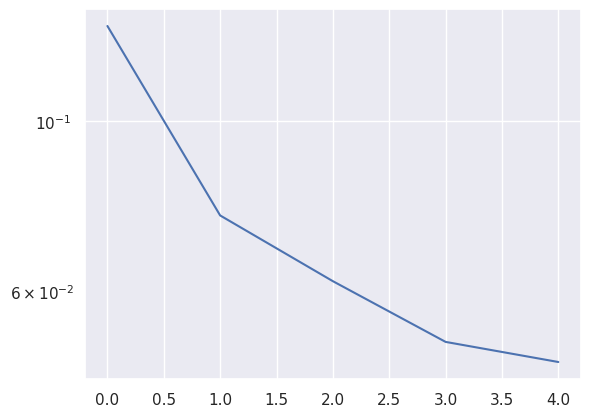

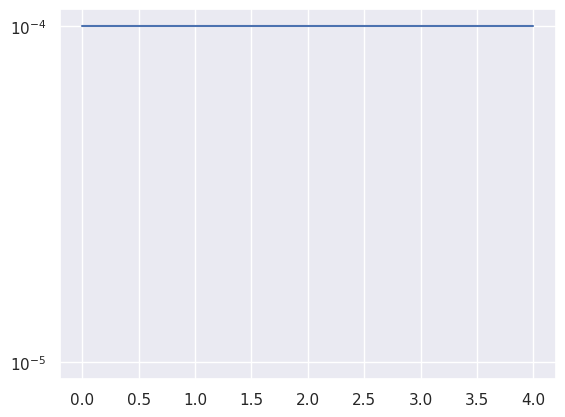

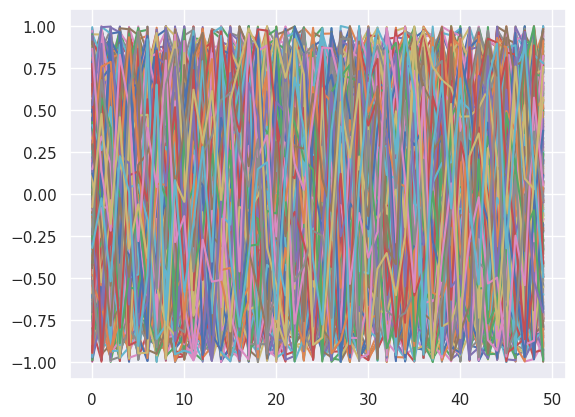

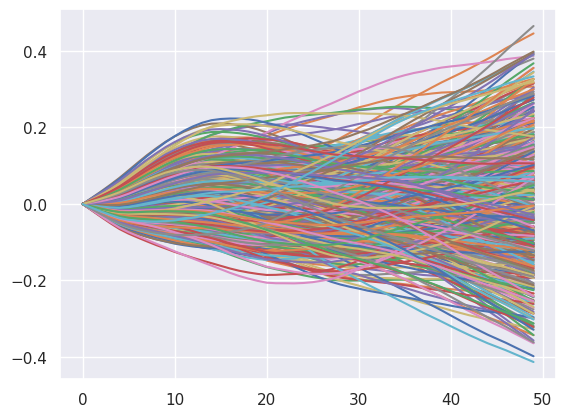

In [6]:

#################3


inp_test = inp
inp_test = torch.tensor(inp_test).float()
inp_test = inp_test.to(device)
# inp_test = torch.vstack([inp_test] * num_batch)
inp_norm_test = (inp_test - inp_mean) / inp_std

theta_init_test = theta_init[0]
theta_init_test = torch.tensor(theta_init_test).float()
theta_init_test = theta_init_test.to(device)
# theta_init_test = torch.vstack([theta_init_test] * num_batch)


vel_init_test = vel_init[0]
vel_init_test = torch.tensor(vel_init_test).float()
vel_init_test = vel_init_test.to(device)

acc_init_test = acc_init[0]
acc_init_test = torch.tensor(acc_init_test).float()
acc_init_test = acc_init_test.to(device)


# vel_init_test = torch.vstack([vel_init_test] * num_batch)


vel_samples_test = vel_samples
vel_samples_test = torch.tensor(vel_samples_test).float()
vel_samples_test = vel_samples_test.to(device)
# vel_samples_test = torch.vstack([vel_samples_test] * num_batch)

with torch.no_grad():
    vel_projected, res_primal_stack, res_fixed_point_stack, accumulated_res_primal, accumulated_res_fixed_point = model.decoder_function(inp_norm_test, vel_init_test, acc_init_test,  vel_samples_test, vel_max, vel_min, acc_max, acc_min, jerk_max, jerk_min, theta_min, theta_max, theta_init_test)



print(res_fixed_point_stack[:, 0].cpu().detach().numpy())
print(res_primal_stack[:, 0].cpu().detach().numpy())

plt.figure(1)
plt.plot(res_fixed_point_stack[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(2)
plt.plot(res_primal_stack[:, 0].cpu().detach().numpy()+0.0001)
plt.yscale('log')


plt.figure(3)

plt.plot(vel_samples_test.T.cpu().detach().numpy())

plt.figure(4)
plt.plot(vel_projected.T.cpu().detach().numpy())

plt.show()


